<a href="https://colab.research.google.com/github/MustofAhmed41/3D-Jeep-Car/blob/main/FL_Suicide_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import imdb
from tensorflow.keras import models, layers, preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.datasets import imdb

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, LSTM, Embedding, SimpleRNN, GRU, RNN
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Suicide_Detection.csv');

In [ ]:
df1.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df = df1.head(50000)

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize the text
max_words = 1000  # Adjust as needed
tokenizer = Tokenizer(num_words=max_words, oov_token="")
tokenizer.fit_on_texts(train_data['text'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# Pad sequences to have consistent length
max_length = 100  # Adjust as needed
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')


label_encoder = LabelEncoder()
train_data['class'] = label_encoder.fit_transform(train_data['class'])
labels = train_data['class'].astype(np.float32).values

label_encoder = LabelEncoder()
test_data['class'] = label_encoder.fit_transform(test_data['class'])
test_labels = test_data['class'].astype(np.float32).values

In [ ]:
# # Build a simple Keras model
# model = tf.keras.Sequential([
#           tf.keras.layers.Embedding(input_dim=max_words, output_dim=64,  name='embedding_layer_1'),
#           tf.keras.layers.LSTM(256,  name='lstm_layer_2'),
#           tf.keras.layers.Dense(128, activation='relu' ,  name='dense_layer_3'),
#           tf.keras.layers.Dense(1, activation='sigmoid',  name='dense_layer_4')
#       ])
# # Compile the model (adjust the loss and optimizer based on your task)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train_tfidf, labels, epochs=1, validation_data=(X_test_tfidf, test_labels))

In [ ]:

tf.random.set_seed(42)
np.random.seed(42)

layers_shape = []
global_loss = []
global_accuracy = []

comm_rounds = 10
local_epoch = 3
local_batch_size = 64
clients_size = 5
num_of_classes = 1
count=0
client_data_size = 1000

In [ ]:
clients_data = [[] for _ in range(clients_size)]

# Shuffle the dataset
indices = np.random.permutation(len(train_padded))
shuffled_images = train_padded[indices]
shuffled_labels = labels[indices]

# Partition the data equally among n clients
for i in range(len(shuffled_images)):
    label = shuffled_labels[i]
    client_idx = i % clients_size  # Distribute evenly among n clients
    clients_data[client_idx].append((shuffled_images[i], label))

# Convert the list of lists to numpy arrays
clients_data = [np.array(client_data) for client_data in clients_data]

# Verify that all clients have an equal number of labels for all 10 digits
for i, client_data in enumerate(clients_data):
    labels, counts = np.unique(client_data[:, 1], return_counts=True)
    print(f"Client {i} label distribution: {dict(zip(labels, counts))}")

Client 0 label distribution: {0.0: 3980, 1.0: 4020}
Client 1 label distribution: {0.0: 3980, 1.0: 4020}
Client 2 label distribution: {0.0: 3967, 1.0: 4033}
Client 3 label distribution: {0.0: 4030, 1.0: 3970}
Client 4 label distribution: {0.0: 4086, 1.0: 3914}


<ipython-input-11-c92da7c3ea54>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clients_data = [np.array(client_data) for client_data in clients_data]


In [ ]:
def get_model_weights(layer_name):
  global count
  count+= 1

  if "embedding" in layer_name:
    weight_file_name = layer_name + "_weights.csv"
    weight = my_array = np.loadtxt(weight_file_name, delimiter=',')
    return [weight]

  if "dense" in layer_name:
    weight_file_name = layer_name + "_weights.csv"
    bias_file_name = layer_name + "_biases.csv"

    weight = my_array = np.loadtxt(weight_file_name, delimiter=',')
    biases = my_array = np.loadtxt(bias_file_name, delimiter=',')

    if weight.ndim == 1:
      weight = np.reshape(weight, (64, 1))

    if count==4:
      biases = biases.reshape(1,)

    return [weight, biases]

  if "rnn" in layer_name:
    weight_file_name = layer_name + "_weights.csv"
    recurrent_file_name = layer_name + "_recurrent.csv"
    bias_file_name = layer_name + "_biases.csv"

    weight  = np.loadtxt(weight_file_name, delimiter=',')
    recurrent  = np.loadtxt(recurrent_file_name, delimiter=',')
    biases  = np.loadtxt(bias_file_name, delimiter=',')

    if weight.ndim == 1:
      weight = np.reshape(weight, (64, 1))

    if count==4:
      biases = biases.reshape(1,)

    return [weight, recurrent, biases]

In [ ]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(input_dim=max_words, output_dim=16, input_length=max_length, name='layer_1'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(32, activation='relu', name='layer_2'),
#     tf.keras.layers.Dense(1, activation='sigmoid', name='layer_3')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# model.fit(train_padded, labels, epochs=1)

In [ ]:
def evaluate_model():
    count = 0
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_length,  name='embedding_layer_1', weights=get_model_weights("aggregated_embedding_layer_1")),
        tf.keras.layers.LSTM(128,  name='lstm_layer_2', weights=get_model_weights("aggregated_lstm_layer_2")),
        tf.keras.layers.Dense(64, activation='relu' , weights=get_model_weights("aggregated_dense_layer_3"),  name='dense_layer_3'),
        tf.keras.layers.Dense(1, activation='sigmoid', weights=get_model_weights("aggregated_dense_layer_4"), name='dense_layer_4')
       ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    loss, accuracy = model.evaluate(test_padded,  test_labels, verbose=2)
    global_loss.append(loss)
    global_accuracy.append(accuracy)

In [ ]:
for k in range(comm_rounds):
  print("Communication Round " + str(k))
  for j,client_data in enumerate(clients_data):
    # Split the data into features (images) and labels
    client_images, client_labels = list(client_data[:, 0]), list(client_data[:, 1])


    # Create a TensorFlow Dataset from the NumPy arrays
    dataset = tf.data.Dataset.from_tensor_slices((client_images, client_labels)).shuffle(len(client_images)).batch(local_batch_size)

    # Define the model architecture
    model = models.Sequential()
    if k==0:
        model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_length,  name='embedding_layer_1'),
        tf.keras.layers.LSTM(128,  name='lstm_layer_2'),
        tf.keras.layers.Dense(64, activation='relu' ,  name='dense_layer_3'),
        tf.keras.layers.Dense(1, activation='sigmoid',  name='dense_layer_4')
    ])
    else:
      count = 0
      model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_length,  name='embedding_layer_1', weights=get_model_weights("aggregated_embedding_layer_1")),
        tf.keras.layers.LSTM(128,  name='lstm_layer_2', weights=get_model_weights("aggregated_lstm_layer_2")),
        tf.keras.layers.Dense(64, activation='relu' , weights=get_model_weights("aggregated_dense_layer_3"),  name='dense_layer_3'),
        tf.keras.layers.Dense(1, activation='sigmoid', weights=get_model_weights("aggregated_dense_layer_4"), name='dense_layer_4')
       ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model using the TensorFlow Dataset
    print("Training Client " + str(j) + " in round " +  str(k))
    model.fit(dataset, epochs=local_epoch, verbose=2)

    for layer in model.layers:
      if hasattr(layer, 'weights'):
        weights = layer.get_weights()
        for i, weight in enumerate(weights):
          file_name = "model_" + str(j+1) + "_" + str(layer.name)
          if "dense" in layer.name:
            if i == 0:
              file_name = file_name + "_weights.csv"
              # print(file_name)
              np.savetxt(file_name, weight, delimiter=',')
            else:
              file_name = file_name + "_biases.csv"
              # print(file_name)
              np.savetxt(file_name, weight, delimiter=',')
          elif "lstm" in layer.name:
            if i == 0:
              file_name = file_name + "_weights.csv"
              # print(file_name)
              np.savetxt(file_name, weight, delimiter=',')
            elif i==1:
              file_name = file_name + "_recurrent.csv"
              # print(file_name)
              np.savetxt(file_name, weight, delimiter=',')
            else:
              file_name = file_name + "_biases.csv"
              # print(file_name)
              np.savetxt(file_name, weight, delimiter=',')
          else:

              file_name = file_name + "_weights.csv"
              # print(file_name)
              np.savetxt(file_name, weight, delimiter=',')

  layer_names_lst = []
  model_names_lst = []
  layers_shape = []
  weights_biases = ["weights.csv", "biases.csv", "recurrent.csv"]

  for i in range(1, len(clients_data)+1):
    model = "model_" + str(i) + "_"
    model_names_lst.append(model)

  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_length,  name='embedding_layer_1'),
    tf.keras.layers.LSTM(128,  name='lstm_layer_2'),
    tf.keras.layers.Dense(64, activation='relu' ,  name='dense_layer_3'),
    tf.keras.layers.Dense(1, activation='sigmoid',  name='dense_layer_4')
  ])

  for layer in model.layers:
    layer_names_lst.append(layer.name+"_")

    if hasattr(layer, 'weights'):
      weights = layer.get_weights()
      temp = []
      for i, weight in enumerate(weights):
        temp.append(weight.shape)

      layers_shape.append(temp)

  for i,layer_name in enumerate(layer_names_lst):
      temp = np.zeros((layers_shape[i][0][0], layers_shape[i][0][1]))

      row, col = temp.shape
      # print('first', temp.shape)
      for j, model_name in enumerate(model_names_lst):
        file_name  = model_name + layer_name + weights_biases[0]
        print(file_name, temp.shape)
        temp2 = np.loadtxt(file_name, dtype=np.float64, delimiter=",")
        if col == 1:
          temp2 = temp2.reshape(row,1)
        temp = temp + temp2
      temp = temp / clients_size
      # print('second', temp.shape)
      save_file_name = 'aggregated_' + layer_name + weights_biases[0]
      np.savetxt(save_file_name, temp, delimiter=',')

  layer_names_lst.remove('embedding_layer_1_')
  layers_shape.remove([(1000, 32)])

  print(layers_shape)
  print(layer_names_lst)

  for x,layer_name in enumerate(layer_names_lst):
    print(layers_shape[x][0][1])
    temp = np.zeros((layers_shape[x][0][1]))
    for j, model_name in enumerate(model_names_lst):
      file_name  = model_name + layer_name + weights_biases[1]
      print(file_name)
      temp = temp + np.loadtxt(file_name, dtype=np.float64, delimiter=",")
    temp = temp / clients_size
    save_file_name = 'aggregated_' + layer_name + weights_biases[1]
    np.savetxt(save_file_name, temp, delimiter=',')

  layer_names_lst.remove('dense_layer_3_')
  layer_names_lst.remove('dense_layer_4_')
  layers_shape.remove([(128, 64), (64,)])
  layers_shape.remove([(64, 1), (1,)])

  for i,layer_name in enumerate(layer_names_lst):
    temp = np.zeros((layers_shape[i][1][0], layers_shape[i][1][1]))
    row, col = temp.shape
    # print('first', temp.shape)
    for j, model_name in enumerate(model_names_lst):
      file_name  = model_name + layer_name + weights_biases[2]
      print(file_name, temp.shape)
      temp2 = np.loadtxt(file_name, dtype=np.float64, delimiter=",")
      if col == 1:
        temp2 = temp2.reshape(row,1)
      temp = temp + temp2
    temp = temp / clients_size
    # print('second', temp.shape)
    save_file_name = 'aggregated_' + layer_name + weights_biases[2]
    np.savetxt(save_file_name, temp, delimiter=',')

    evaluate_model()


Communication Round 0
Training Client 0 in round 0
Epoch 1/3
125/125 - 16s - loss: 0.5058 - accuracy: 0.7757 - 16s/epoch - 129ms/step
Epoch 2/3
125/125 - 14s - loss: 0.3067 - accuracy: 0.8907 - 14s/epoch - 110ms/step
Epoch 3/3
125/125 - 14s - loss: 0.2576 - accuracy: 0.9105 - 14s/epoch - 111ms/step
Training Client 1 in round 0
Epoch 1/3
125/125 - 15s - loss: 0.5128 - accuracy: 0.7724 - 15s/epoch - 122ms/step
Epoch 2/3
125/125 - 14s - loss: 0.3139 - accuracy: 0.8826 - 14s/epoch - 112ms/step
Epoch 3/3
125/125 - 14s - loss: 0.2594 - accuracy: 0.9071 - 14s/epoch - 110ms/step
Training Client 2 in round 0
Epoch 1/3
125/125 - 16s - loss: 0.4768 - accuracy: 0.7964 - 16s/epoch - 128ms/step
Epoch 2/3
125/125 - 14s - loss: 0.2921 - accuracy: 0.8953 - 14s/epoch - 115ms/step
Epoch 3/3
125/125 - 14s - loss: 0.2473 - accuracy: 0.9136 - 14s/epoch - 112ms/step
Training Client 3 in round 0
Epoch 1/3
125/125 - 16s - loss: 0.4861 - accuracy: 0.7868 - 16s/epoch - 126ms/step
Epoch 2/3
125/125 - 14s - loss: 

In [ ]:
global_loss = np.array(global_loss)
global_accuracy = np.array(global_accuracy)
print(global_loss)
print(global_accuracy)
print(len(global_loss))


[]
[]
0


In [ ]:


x_values = np.arange(1, len(global_loss) + 1)
# Plotting the graph
plt.plot(x_values, global_loss, marker='o', linestyle='--', color='r')
plt.title('Loss Vs Communication Round')
plt.xlabel('Communication Round')
plt.ylabel('Global Loss')
plt.xticks(x_values)
plt.legend()
plt.show()

# Plot the accuracy values

x_values = np.arange(1, len(global_accuracy) + 1)
# Plotting the graph
plt.plot(x_values, global_accuracy, marker='o', linestyle='--', color='g')
plt.title('Accuracy Vs Communication Round')
plt.xlabel('Communication Round')
plt.ylabel('Global Accuracy')
plt.xticks(x_values)
plt.legend()
plt.show()

In [ ]:
layer_names_lst = []
model_names_lst = []
layers_shape = []
weights_biases = ["weights.csv", "biases.csv", "recurrent.csv"]

for i in range(1, len(clients_data)+1):
  model = "model_" + str(i) + "_"
  model_names_lst.append(model)

print(layer_names_lst)
print(model_names_lst)

[]
['model_1_', 'model_2_', 'model_3_', 'model_4_', 'model_5_']


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_length,  name='embedding_layer_1'),
    tf.keras.layers.LSTM(128,  name='lstm_layer_2'),
    tf.keras.layers.Dense(64, activation='relu' ,  name='dense_layer_3'),
    tf.keras.layers.Dense(1, activation='sigmoid',  name='dense_layer_4')
])

In [ ]:
for layer in model.layers:
    print(f"Layer Name: {layer.name}, Output Shape: {layer.output_shape}")

Layer Name: embedding_layer_1, Output Shape: (None, 100, 32)
Layer Name: lstm_layer_2, Output Shape: (None, 128)
Layer Name: dense_layer_3, Output Shape: (None, 64)
Layer Name: dense_layer_4, Output Shape: (None, 1)


In [ ]:
for layer in model.layers:
  layer_names_lst.append(layer.name+"_")

  if hasattr(layer, 'weights'):
    weights = layer.get_weights()
    temp = []
    for i, weight in enumerate(weights):
      temp.append(weight.shape)

    layers_shape.append(temp)

In [ ]:
print(layers_shape)
print(layer_names_lst)

[[(1000, 32)], [(32, 512), (128, 512), (512,)], [(128, 64), (64,)], [(64, 1), (1,)]]
['embedding_layer_1_', 'lstm_layer_2_', 'dense_layer_3_', 'dense_layer_4_']


In [ ]:
for i,layer_name in enumerate(layer_names_lst):
    temp = np.zeros((layers_shape[i][0][0], layers_shape[i][0][1]))

    row, col = temp.shape
    # print('first', temp.shape)
    for j, model_name in enumerate(model_names_lst):
      file_name  = model_name + layer_name + weights_biases[0]
      print(file_name, temp.shape)
      temp2 = np.loadtxt(file_name, dtype=np.float64, delimiter=",")
      if col == 1:
        temp2 = temp2.reshape(row,1)
      temp = temp + temp2
    temp = temp / clients_size
    # print('second', temp.shape)
    save_file_name = 'aggregated_' + layer_name + weights_biases[0]
    np.savetxt(save_file_name, temp, delimiter=',')

model_1_embedding_layer_1_weights.csv (1000, 32)
model_2_embedding_layer_1_weights.csv (1000, 32)
model_3_embedding_layer_1_weights.csv (1000, 32)
model_4_embedding_layer_1_weights.csv (1000, 32)
model_5_embedding_layer_1_weights.csv (1000, 32)
model_1_lstm_layer_2_weights.csv (32, 512)
model_2_lstm_layer_2_weights.csv (32, 512)
model_3_lstm_layer_2_weights.csv (32, 512)
model_4_lstm_layer_2_weights.csv (32, 512)
model_5_lstm_layer_2_weights.csv (32, 512)
model_1_dense_layer_3_weights.csv (128, 64)
model_2_dense_layer_3_weights.csv (128, 64)
model_3_dense_layer_3_weights.csv (128, 64)
model_4_dense_layer_3_weights.csv (128, 64)
model_5_dense_layer_3_weights.csv (128, 64)
model_1_dense_layer_4_weights.csv (64, 1)
model_2_dense_layer_4_weights.csv (64, 1)
model_3_dense_layer_4_weights.csv (64, 1)
model_4_dense_layer_4_weights.csv (64, 1)
model_5_dense_layer_4_weights.csv (64, 1)


In [ ]:
layer_names_lst.remove('embedding_layer_1_')
layers_shape.remove([(1000, 32)])
print(layers_shape)
print(layer_names_lst)

[[(32, 512), (128, 512), (512,)], [(128, 64), (64,)], [(64, 1), (1,)]]
['lstm_layer_2_', 'dense_layer_3_', 'dense_layer_4_']


In [ ]:
for i,layer_name in enumerate(layer_names_lst):
  print(layers_shape[i][0][1])
  temp = np.zeros((layers_shape[i][0][1]))
  for j, model_name in enumerate(model_names_lst):
    file_name  = model_name + layer_name + weights_biases[1]
    print(file_name)
    temp = temp + np.loadtxt(file_name, dtype=np.float64, delimiter=",")
  temp = temp / clients_size
  save_file_name = 'aggregated_' + layer_name + weights_biases[1]
  np.savetxt(save_file_name, temp, delimiter=',')

512
model_1_lstm_layer_2_biases.csv
model_2_lstm_layer_2_biases.csv
model_3_lstm_layer_2_biases.csv
model_4_lstm_layer_2_biases.csv
model_5_lstm_layer_2_biases.csv
64
model_1_dense_layer_3_biases.csv
model_2_dense_layer_3_biases.csv
model_3_dense_layer_3_biases.csv
model_4_dense_layer_3_biases.csv
model_5_dense_layer_3_biases.csv
1
model_1_dense_layer_4_biases.csv
model_2_dense_layer_4_biases.csv
model_3_dense_layer_4_biases.csv
model_4_dense_layer_4_biases.csv
model_5_dense_layer_4_biases.csv


In [ ]:
layer_names_lst.remove('dense_layer_3_')
layer_names_lst.remove('dense_layer_4_')
layers_shape.remove([(128, 64), (64,)])
layers_shape.remove([(64, 1), (1,)])
print(layers_shape)
print(layer_names_lst)

[[(32, 512), (128, 512), (512,)]]
['lstm_layer_2_']


In [ ]:
for i,layer_name in enumerate(layer_names_lst):
    temp = np.zeros((layers_shape[i][1][0], layers_shape[i][1][1]))
    row, col = temp.shape
    # print('first', temp.shape)
    for j, model_name in enumerate(model_names_lst):
      file_name  = model_name + layer_name + weights_biases[2]
      print(file_name, temp.shape)
      temp2 = np.loadtxt(file_name, dtype=np.float64, delimiter=",")
      if col == 1:
        temp2 = temp2.reshape(row,1)
      temp = temp + temp2
    temp = temp / clients_size
    # print('second', temp.shape)
    save_file_name = 'aggregated_' + layer_name + weights_biases[2]
    np.savetxt(save_file_name, temp, delimiter=',')

model_1_lstm_layer_2_recurrent.csv (128, 512)
model_2_lstm_layer_2_recurrent.csv (128, 512)
model_3_lstm_layer_2_recurrent.csv (128, 512)
model_4_lstm_layer_2_recurrent.csv (128, 512)
model_5_lstm_layer_2_recurrent.csv (128, 512)


In [ ]:
# import numpy as np

# # Load the MNIST data
# (train_images, train_labels), (test_images, test_labels) = imdb.load_data(num_words=10000)

# data = np.concatenate((train_images, test_images), axis=0)
# targets = np.concatenate((train_labels, test_labels), axis=0)


In [ ]:
# def vectorize(sequences, dimension = 10000):
#  results = np.zeros((len(sequences), dimension))
#  for i, sequence in enumerate(sequences):
#   results[i, sequence] = 1
#  return results

In [ ]:
# data = vectorize(data)
# targets = np.array(targets).astype("float32")
# test_images = data[:10000]
# test_labels = targets[:10000]
# train_images = data[10000:]
# train_labels = targets[10000:]

In [ ]:
def get_model_weights(layer_name):
  global count
  count+= 1

  if "embedding" in layer_name:
    weight_file_name = layer_name + "_weights.csv"
    weight = my_array = np.loadtxt(weight_file_name, delimiter=',')
    return [weight]

  if "dense" in layer_name:
    weight_file_name = layer_name + "_weights.csv"
    bias_file_name = layer_name + "_biases.csv"

    weight = my_array = np.loadtxt(weight_file_name, delimiter=',')
    biases = my_array = np.loadtxt(bias_file_name, delimiter=',')

    if weight.ndim == 1:
      weight = np.reshape(weight, (128, 1))

    if count==4:
      biases = biases.reshape(1,)

    return [weight, biases]

  if "rnn" in layer_name:
    weight_file_name = layer_name + "_weights.csv"
    recurrent_file_name = layer_name + "_recurrent.csv"
    bias_file_name = layer_name + "_biases.csv"

    weight  = np.loadtxt(weight_file_name, delimiter=',')
    recurrent  = np.loadtxt(recurrent_file_name, delimiter=',')
    biases  = np.loadtxt(bias_file_name, delimiter=',')

    if weight.ndim == 1:
      weight = np.reshape(weight, (128, 1))

    if count==4:
      biases = biases.reshape(1,)

    return [weight, recurrent, biases]

In [ ]:
layer_names_lst = ["layer_1_", "layer_2_", "layer_3_"]
model_names_lst = []
weights_biases = ["weights.csv", "biases.csv"]

for i in range(1, len(clients_data)+1):
  model = "model_" + str(i) + "_"
  model_names_lst.append(model)

print(layer_names_lst)
print(model_names_lst)

['layer_1_', 'layer_2_', 'layer_3_']
['model_1_', 'model_2_', 'model_3_', 'model_4_', 'model_5_', 'model_6_', 'model_7_', 'model_8_', 'model_9_', 'model_10_']


In [ ]:
def get_model_weights(layer_name):
  global count
  count+= 1
  weight_file_name = layer_name + "_weights.csv"
  bias_file_name = layer_name + "_biases.csv"
  weight = my_array = np.loadtxt(weight_file_name, delimiter=',')
  biases = my_array = np.loadtxt(bias_file_name, delimiter=',')

  if weight.ndim == 1:
    weight = np.reshape(weight, (256, 1))

  if count==3:
    biases = biases.reshape(1,)

  return [weight, biases]

In [ ]:
def fed_avg():
  for i,layer_name in enumerate(layer_names_lst):
    temp = np.zeros((layers_shape[i][0][0], layers_shape[i][0][1]))
    row, col = temp.shape
    # print('first', temp.shape)
    for j, model_name in enumerate(model_names_lst):
      file_name  = model_name + layer_name + weights_biases[0]
      temp2 = np.loadtxt(file_name, dtype=np.float64, delimiter=",")
      if col == 1:
        temp2 = temp2.reshape(row,1)
      temp = temp + temp2
    temp = temp / clients_size
    # print('second', temp.shape)
    save_file_name = 'aggregated_' + layer_name + weights_biases[0]
    np.savetxt(save_file_name, temp, delimiter=',')

  for i,layer_name in enumerate(layer_names_lst):
    temp = np.zeros((layers_shape[i][1][0]))
    for j, model_name in enumerate(model_names_lst):
      file_name  = model_name + layer_name + weights_biases[1]
      temp = temp + np.loadtxt(file_name, dtype=np.float64, delimiter=",")
    temp = temp / clients_size
    save_file_name = 'aggregated_' + layer_name + weights_biases[1]
    np.savetxt(save_file_name, temp, delimiter=',')

In [ ]:
def evaluate_global_model():
  global count
  count = 0
  model = keras.models.Sequential()
  model.add(Dense(512, activation='relu', weights=get_model_weights("aggregated_layer_1"), input_dim=max_words, name="layer_1"))
  model.add(Dense(256, activation='relu',  weights=get_model_weights("aggregated_layer_2"), input_dim=max_words, name="layer_2"))
  model.add(Dense(1, activation='sigmoid',weights=get_model_weights("aggregated_layer_3"), name="layer_3"))

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  loss, accuracy = model.evaluate(X_test_tfidf,  test_labels, verbose=2)
  global_loss.append(loss)
  global_accuracy.append(accuracy)

In [ ]:
for k in range(comm_rounds):
  print("Communication Round " + str(k))
  for j,client_data in enumerate(clients_data):
    # Split the data into features (images) and labels
    client_images, client_labels = list(client_data[:, 0]), list(client_data[:, 1])


    # Create a TensorFlow Dataset from the NumPy arrays
    dataset = tf.data.Dataset.from_tensor_slices((client_images, client_labels)).shuffle(len(client_images)).batch(local_batch_size)

    # Define the model architecture
    model = models.Sequential()
    if k==0:
      model.add(Dense(512, activation='relu', input_dim=max_words, name="layer_1"))
      model.add(Dense(256, activation='relu', input_dim=max_words, name="layer_2"))
      model.add(Dense(1, activation='sigmoid', name="layer_3"))
    else:
      count = 0
      model.add(Dense(512, activation='relu', weights=get_model_weights("aggregated_layer_1"), input_dim=max_words, name="layer_1"))
      model.add(Dense(256, activation='relu',  weights=get_model_weights("aggregated_layer_2"), input_dim=max_words, name="layer_2"))
      model.add(Dense(1, activation='sigmoid',weights=get_model_weights("aggregated_layer_3"), name="layer_3"))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model using the TensorFlow Dataset
    print("Training Client " + str(j) + " in round " +  str(k))
    model.fit(dataset, epochs=local_epoch)

    for layer in model.layers:
      if hasattr(layer, 'weights'):
        weights = layer.get_weights()
        for i, weight in enumerate(weights):
          file_name = "model_" + str(j+1) + "_" + str(layer.name)
          if i == 0:
            file_name = file_name + "_weights.csv"
            # print(file_name)
            np.savetxt(file_name, weight, delimiter=',')
          else:
            file_name = file_name + "_biases.csv"
            # print(file_name)
            np.savetxt(file_name, weight, delimiter=',')

    if k == 0 and j==0:
      for layer in model.layers:
        if hasattr(layer, 'weights'):
          weights = layer.get_weights()
          temp = []
          for i, weight in enumerate(weights):
            temp.append(weight.shape)

          layers_shape.append(temp)

  fed_avg()
  evaluate_global_model()





Communication Round 0
Training Client 0 in round 0
Epoch 1/4
200/200 [==============================] - 3s 10ms/step - loss: 0.3366 - accuracy: 0.8575
Epoch 2/4
200/200 [==============================] - 1s 6ms/step - loss: 0.2361 - accuracy: 0.9116
Epoch 3/4
200/200 [==============================] - 1s 6ms/step - loss: 0.1929 - accuracy: 0.9280
Epoch 4/4
200/200 [==============================] - 1s 6ms/step - loss: 0.1398 - accuracy: 0.9545
Training Client 1 in round 0
Epoch 1/4
200/200 [==============================] - 2s 6ms/step - loss: 0.3577 - accuracy: 0.8473
Epoch 2/4
200/200 [==============================] - 2s 11ms/step - loss: 0.2471 - accuracy: 0.9013
Epoch 3/4
200/200 [==============================] - 2s 9ms/step - loss: 0.2040 - accuracy: 0.9227
Epoch 4/4
200/200 [==============================] - 1s 6ms/step - loss: 0.1444 - accuracy: 0.9509
Training Client 2 in round 0
Epoch 1/4
200/200 [==============================] - 2s 6ms/step - loss: 0.3470 - accuracy: 0.843

In [ ]:
global_loss = np.array(global_loss)
global_accuracy = np.array(global_accuracy)
print(global_loss)
print(global_accuracy)
print(len(global_loss))

[0.67270172 0.3353793  0.51795876 0.49381709 0.48878336 0.52536571
 0.54968685 0.5707894  0.59542716 0.60055035 0.6179297  0.62663883
 0.62418449 0.66151851 0.66443306 0.68055451 0.69345903 0.71650791
 0.70944864 0.71354496 0.71516401 0.7467168  0.75621694 0.75548404
 0.7733618  0.79946411 0.81059706 0.80548245 0.83627093 0.8258211 ]
[0.50962502 0.86562502 0.82843751 0.85531253 0.86443752 0.85912502
 0.85831249 0.85931247 0.85993749 0.86224997 0.86368752 0.86462498
 0.86825001 0.86362499 0.86750001 0.86681253 0.86750001 0.86506248
 0.8688125  0.87124997 0.87274998 0.87050003 0.87124997 0.87512499
 0.87287498 0.87037498 0.87318748 0.87281251 0.87150002 0.87712502]
30


In [ ]:
# global_loss = global_loss.tolist()
# global_accuracy = global_accuracy.tolist()

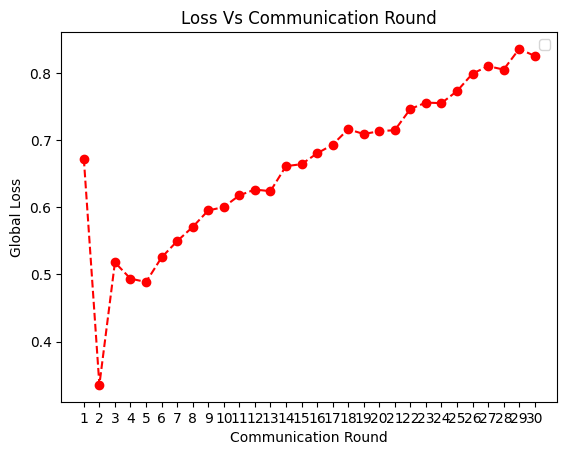

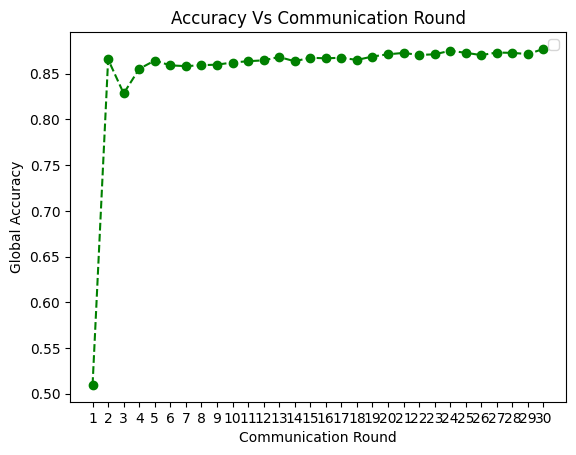

In [ ]:

x_values = np.arange(1, len(global_loss) + 1)
# Plotting the graph
plt.plot(x_values, global_loss, marker='o', linestyle='--', color='r')
plt.title('Loss Vs Communication Round')
plt.xlabel('Communication Round')
plt.ylabel('Global Loss')
plt.xticks(x_values)
plt.legend()
plt.show()

# Plot the accuracy values

x_values = np.arange(1, len(global_accuracy) + 1)
# Plotting the graph
plt.plot(x_values, global_accuracy, marker='o', linestyle='--', color='g')
plt.title('Accuracy Vs Communication Round')
plt.xlabel('Communication Round')
plt.ylabel('Global Accuracy')
plt.xticks(x_values)
plt.legend()
plt.show()